In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
from feature_maps import MediumFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer
from sklearn.svm import SVC
from shot_based_kernel import ShotBasedQuantumKernel

In [58]:
margin = -0.1
Ms = 2**np.arange(6,12)
N = 1000
Cs = [10,1000]
tol = 1e-4

sep = 'separable' if margin > 0 else 'overlap'

In [61]:
y = np.array(pd.read_csv(f'data/2-qubits/{margin}_y_2048.csv')).reshape(-1)
X = np.array(pd.read_csv(f'data/2-qubits/{margin}_X_2048.csv'))

def load_data(M, seed = 42):
        assert (M <= 2048) & (M % 2 == 0)
        np.random.seed(seed)
        indices1 = np.random.randint(0,np.sum(y == 1),M//2)
        indices2 = np.random.randint(0,np.sum(y == -1),M//2)

        X1 = X[y == 1][indices1]
        y1 = y[y == 1][indices1]
        X2 = X[y == -1][indices2]
        y2 = y[y == -1][indices1]

        X12 = np.vstack([X1,X2])
        y12 = np.append(y1,y2)

        shuffle = np.random.choice(M, M, replace=False)
        return X12[shuffle], y12[shuffle]

In [4]:
# Feature map for the experiment
feature_map = MediumFeatureMap(2,4)

# Kernel
adhoc_backend = QuantumInstance(Aer.get_backend('statevector_simulator'))
adhoc_kernel = QuantumKernel(feature_map=feature_map.get_reduced_params_circuit(), quantum_instance=adhoc_backend)

In [51]:
R = 1024
E = []

Ms = 2**np.arange(2,9)
for M in Ms:
    X_,y_ = load_data(M)
    K = adhoc_kernel.evaluate(X_)
    s_k = ShotBasedQuantumKernel(K)
    K_R = s_k.approximate_kernel(R)
    
    E.append(np.linalg.norm(K-K_R,ord=2))
    

array([ 0.66891755, -4.39943511])

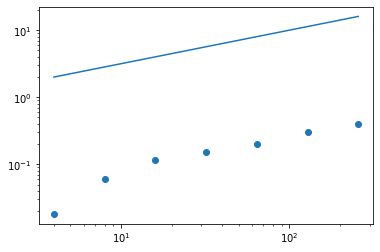

In [52]:
plt.scatter(Ms,E)
plt.yscale('log')
plt.xscale('log')
plt.plot(Ms,np.sqrt(Ms))
p = np.polyfit(np.log(Ms),np.log(E),1)
p

In [65]:
R = 1024
E2= []

Ms = 2**np.arange(3,9)
for M in Ms:
    X_,y_ = load_data(M)
    K = adhoc_kernel.evaluate(X_)
    svc = SVC(kernel='precomputed',C=10)
    svc.fit(K,y_)
    alphas = np.zeros(y_.shape)
    alphas[svc.support_] = svc.dual_coef_

    s_k = ShotBasedQuantumKernel(K)
    K_R = s_k.approximate_kernel(R)
    svc_R = SVC(kernel='precomputed',C=10)
    svc_R.fit(K_R,y_)
    alphas_R = np.zeros(y_.shape)
    alphas_R[svc_R.support_] = svc_R.dual_coef_
    
    E2.append(np.linalg.norm(alphas - alphas_R))
    

array([ 0.92050601, -1.05227211])

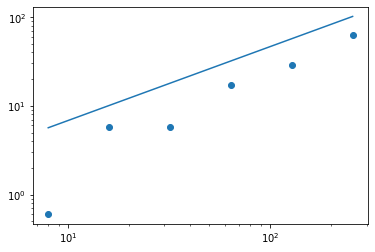

In [66]:
plt.scatter(Ms,E2)
plt.yscale('log')
plt.xscale('log')
plt.plot(Ms,Ms**(5/6))
p = np.polyfit(np.log(Ms[1:]),np.log(E2[1:]),1)
p

In [55]:
R = 1024
E3 = []

Ms = 2**np.arange(4,11)
for M in Ms:
    X_,y_ = load_data(M)
    K = adhoc_kernel.evaluate(X_)
    svc = SVC(kernel='precomputed',C=10,random_state=42)
    svc.fit(K,y_)
    alphas = np.zeros(y_.shape)
    alphas[svc.support_] = svc.dual_coef_

    E3.append(np.linalg.norm(alphas))
    

array([0.32718884, 1.7322517 ])

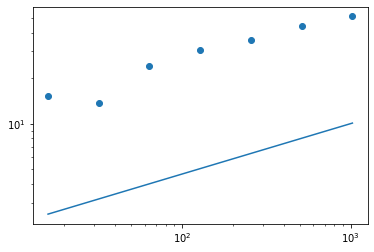

In [39]:
plt.scatter(Ms,E3)
plt.yscale('log')
plt.xscale('log')
plt.plot(Ms,Ms**(1/3))
p = np.polyfit(np.log(Ms),np.log(E3),1)
p